In [1]:
########
# Concatenate CMIP6 files and regrid to a 2.5x2.5 grid
# Save as netCDF file
# Extract seasonal averages and save as netCDF file

In [1]:
import matplotlib.pyplot as plt

import xarray as xr
import xesmf as xe
import numpy as np
import cftime
import pandas as pd

In [2]:
def convert_to_cftime(ds):
    if "time" in ds:
        time_values = ds["time"].values

        # Convert numpy.datetime64 to datetime objects using pandas.to_datetime
        datetime_values = pd.to_datetime(time_values)

        # Convert each datetime object to cftime.DatetimeNoLeap
        cftime_times = [
            cftime.DatetimeNoLeap(t.year, t.month, t.day, t.hour, t.minute, t.second)
            for t in datetime_values
        ]

        # Replace the time values in the dataset
        ds["time"] = ("time", cftime_times)

    return ds

In [4]:
computer = "marcodia"

ddir_in_ref = "/Users/" + computer + "/Documents/Projects/temp_thresh_shash/data/"
ddir_in_files = "/Users/" + computer + "/Downloads/"

ddir_out = "/Users/" + computer + "/Documents/Projects/temp_thresh_shash/data/"

variable = "tasmin"
model = "ACCESS-CM2"  # "ACCESS-CM2" #"CanESM5" #'MPI-ESM1-2-LR' #'MIROC6'
identifier = [
    "r1i1p1f1",
    "r2i1p1f1",
    "r3i1p1f1",
    "r4i1p1f1",
    "r5i1p1f1",
    "r6i1p1f1",
    "r7i1p1f1",
    "r8i1p1f1",
    "r9i1p1f1",
    "r10i1p1f1",
]
ssp_list = ["ssp126", "ssp245", "ssp370", "ssp585"]


multi_member_monthly = []
multi_member_mon_avg = []

reference_ds = xr.open_dataset(
    ddir_in_ref + "tas_Amon_historical_ssp245_CanESM5_r1i1p1f1_ann_mean_2pt5degree.nc"
)

In [ ]:
for ssp in ssp_list:
    multi_member_monthly = []
    multi_member_mon_avg = []

    for id in identifier:

        ds1 = xr.open_dataset(
            ddir_in_files
            + variable
            + "_Amon_"
            + model
            + "_historical_"
            + id
            + "_gn_185001-201412.nc"
        )
        ds2 = xr.open_dataset(
            ddir_in_files
            + variable
            + "_Amon_"
            + model
            + "_"
            + ssp
            + "_"
            + id
            + "_gn_201501-210012.nc"
        )

        # Check ds1
        if isinstance(ds1["time"].values[0], np.datetime64):
            ds1 = convert_to_cftime(ds1)

        # Check ds2
        if isinstance(ds2["time"].values[0], np.datetime64):
            ds2 = convert_to_cftime(ds2)

        # Extract the grid from the reference dataset
        lat_target = reference_ds["lat"]
        lon_target = reference_ds["lon"]

        # Create the target grid using the lat and lon from the reference dataset
        target_grid = xr.Dataset(
            {
                "lat": (["lat"], lat_target.data),
                "lon": (["lon"], lon_target.data),
            }
        )

        # Create a regridder for ds1 using the reference grid
        regridder_ds1 = xe.Regridder(ds1, target_grid, method="bilinear", periodic=True)
        ds1_regridded = regridder_ds1(ds1)  # regrid

        regridder_ds2 = xe.Regridder(ds2, target_grid, method="bilinear", periodic=True)
        ds2_regridded = regridder_ds2(ds2)

        # Concatenate along the 'time' dimension
        concatenated_ds = xr.concat([ds1_regridded, ds2_regridded], dim="time")
        # Add a new dimension called "member" with size 1
        concatenated_ds = concatenated_ds.expand_dims("member")

        # Extract the months for June, July, and August (5, 6, 7)
        months = concatenated_ds["time.month"]

        # Select JJA months: June, July, August - the months indexing starts at 1
        months_extract = concatenated_ds.isel(time=months.isin([6, 7, 8]))

        # Create a new dimension for year
        months_extract["year"] = concatenated_ds["time.year"]

        # Group by year and calculate the seasonal mean
        mon_avg = months_extract.groupby("year").mean("time")
        mon_avg = mon_avg.rename({"year": "time"})

        mon_avg = mon_avg.drop_vars("height")

        mon_avg_rearrange = mon_avg.transpose("member", "time", "lat", "lon")

        # Rearrange and drop extra indices
        mon_avg_save = mon_avg_rearrange[["member", "time", "lat", "lon", "tasmin"]]
        mon_avg_save["time"] = reference_ds["time"]
        mon_avg_save = mon_avg_save.drop_indexes("member")
        # print(mon_avg_save.shape)

        # mon_avg_save.to_netcdf(ddir_out+variable+'_Amon_hist_'+ssp+'_'+model+'_'+id+'_JJA_gn_185001-210012_2pt5deg.nc')

        multi_member_monthly.append(concatenated_ds)
        multi_member_mon_avg.append(mon_avg_save)

    multi_member_monthly = xr.concat(multi_member_monthly, dim="member")
    multi_member_mon_avg = xr.concat(multi_member_mon_avg, dim="member")

    if model == "ACCESS-CM2":
        months = multi_member_monthly.time.dt.month

        # Shift the months along the 'time' dimension
        shifted_months = months.shift(time=1)

        # Create a mask where the current month is not equal to the previous month
        mask = months != shifted_months

        # Apply the mask to filter out the unwanted timestamps
        multi_member_monthly = multi_member_monthly.where(mask, drop=True)

    multi_member_monthly.to_netcdf(
        ddir_out
        + variable
        + "_Amon_hist_"
        + ssp
        + "_"
        + model
        + "_r1-10i1p1f1_monthly_gn_185001-210012_2pt5deg.nc"
    )
    # multi_member_mon_avg.to_netcdf(ddir_out+variable+'_Amon_hist_'+ssp+'_'+model+'_r1-10i1p1f1_JJA_gn_185001-210012_2pt5deg.nc')

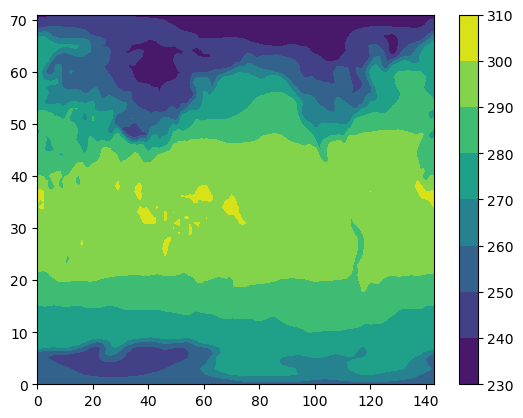

In [22]:
plt.contourf(np.mean(multi_member_monthly.tasmin[0, 0:1, :, :], axis=0))
plt.colorbar()

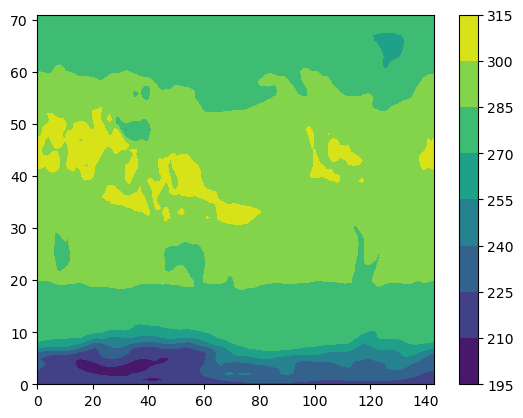

In [23]:
plt.contourf(np.mean(concatenated_ds.tasmin[0, 5:8, :, :], axis=0))
plt.colorbar()

# Compute Global mean temperature


In [138]:
ddir_in_ref = "/Users/" + computer + "/Documents/Projects/temp_thresh_shash/data/"
ddir_in_files = "/Users/" + computer + "/Downloads/"
ddir_out = "/Users/" + computer + "/Documents/Projects/temp_thresh_shash/data/"

variable = "tas"
model = "MIROC6"  # , 'CanESM5'
identifier = [
    "r1i1p1f1",
    "r2i1p1f1",
    "r3i1p1f1",
    "r4i1p1f1",
    "r5i1p1f1",
    "r6i1p1f1",
    "r7i1p1f1",
    "r8i1p1f1",
    "r9i1p1f1",
    "r10i1p1f1",
]
ssp_list = ["ssp126", "ssp245", "ssp370", "ssp585"]


reference_ds = xr.open_dataset(
    ddir_in_ref + "tas_Amon_historical_ssp245_CanESM5_r1i1p1f1_ann_mean_2pt5degree.nc"
)
for ssp in ssp_list:
    multi_member_monthly = []
    multi_member_mon_avg = []

    for id in identifier:

        ds1 = xr.open_dataset(
            ddir_in_files
            + variable
            + "_Amon_"
            + model
            + "_historical_"
            + id
            + "_gn_185001-201412.nc"
        )
        ds2 = xr.open_dataset(
            ddir_in_files
            + variable
            + "_Amon_"
            + model
            + "_"
            + ssp
            + "_"
            + id
            + "_gn_201501-210012.nc"
        )
        # Check ds1
        if isinstance(ds1["time"].values[0], np.datetime64):
            ds1 = convert_to_cftime(ds1)

        # Check ds2
        if isinstance(ds2["time"].values[0], np.datetime64):
            ds2 = convert_to_cftime(ds2)

        # Extract the grid from the reference dataset
        lat_target = reference_ds["lat"]
        lon_target = reference_ds["lon"]

        # Create the target grid using the lat and lon from the reference dataset
        target_grid = xr.Dataset(
            {
                "lat": (["lat"], lat_target.data),
                "lon": (["lon"], lon_target.data),
            }
        )

        # Create a regridder for ds1 using the reference grid
        regridder_ds1 = xe.Regridder(ds1, target_grid, method="bilinear", periodic=True)
        ds1_regridded = regridder_ds1(ds1)  # regrid

        regridder_ds2 = xe.Regridder(ds2, target_grid, method="bilinear", periodic=True)
        ds2_regridded = regridder_ds2(ds2)

        # Concatenate along the 'time' dimension
        concatenated_ds = xr.concat([ds1_regridded, ds2_regridded], dim="time")
        # Add a new dimension called "member" with size 1
        concatenated_ds = concatenated_ds.expand_dims("member")

        # concatenated_ds.to_netcdf(ddir_out+variable+'_Amon_hist_'+ssp+'_'+model+'_'+id+'_monthly_gn_185001-210012_2pt5deg.nc')

        # Extract the months for June, July, and August (5, 6, 7)
        months = concatenated_ds["time.month"]

        # Select JJA months: June, July, August - the months indexing starts at 1
        months_extract = concatenated_ds.isel(
            time=months.isin([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
        )

        # Create a new dimension for year
        months_extract["year"] = concatenated_ds["time.year"]

        # Group by year and calculate the seasonal mean
        mon_avg = months_extract.groupby("year").mean("time")
        mon_avg = mon_avg.rename({"year": "time"})

        mon_avg = mon_avg.drop_vars("height")

        mon_avg_rearrange = mon_avg.transpose("member", "time", "lat", "lon")

        # Rearrange and drop extra indices
        mon_avg_save = mon_avg_rearrange[["member", "time", "lat", "lon", "tas"]]
        mon_avg_save["time"] = reference_ds["time"]
        mon_avg_save = mon_avg_save.drop_indexes("member")

        # mon_avg_save.to_netcdf(ddir_out+variable+'_Amon_hist_'+ssp+'_'+model+'_'+id+'_JJA_gn_185001-210012_2pt5deg.nc')

        multi_member_monthly.append(concatenated_ds)
        multi_member_mon_avg.append(mon_avg_save)

    multi_member_monthly = xr.concat(multi_member_monthly, dim="member")
    multi_member_mon_avg = xr.concat(multi_member_mon_avg, dim="member")

    multi_member_monthly.to_netcdf(
        ddir_out
        + variable
        + "_Amon_hist_"
        + ssp
        + "_"
        + model
        + "_r1-10i1p1f1_monthly_gn_185001-210012_2pt5deg.nc"
    )
    multi_member_mon_avg.to_netcdf(
        ddir_out
        + variable
        + "_Amon_hist_"
        + ssp
        + "_"
        + model
        + "_r1-10i1p1f1_ann_mean_gn_185001-210012_2pt5deg.nc"
    )

/var/folders/v6/n_npdtk14cn2qb_fv2f98h1w0000gq/T/ipykernel_34697/1241109856.py:92: SerializationWarning: saving variable time with floating point data as an integer dtype without any _FillValue to use for NaNs
  multi_member_monthly.to_netcdf(ddir_out+variable+'_Amon_hist_'+ssp+'_'+model+'_r1-10i1p1f1_monthly_gn_185001-210012_2pt5deg.nc')
/var/folders/v6/n_npdtk14cn2qb_fv2f98h1w0000gq/T/ipykernel_34697/1241109856.py:92: SerializationWarning: saving variable time with floating point data as an integer dtype without any _FillValue to use for NaNs
  multi_member_monthly.to_netcdf(ddir_out+variable+'_Amon_hist_'+ssp+'_'+model+'_r1-10i1p1f1_monthly_gn_185001-210012_2pt5deg.nc')
/var/folders/v6/n_npdtk14cn2qb_fv2f98h1w0000gq/T/ipykernel_34697/1241109856.py:92: SerializationWarning: saving variable time with floating point data as an integer dtype without any _FillValue to use for NaNs
  multi_member_monthly.to_netcdf(ddir_out+variable+'_Amon_hist_'+ssp+'_'+model+'_r1-10i1p1f1_monthly_gn_1850

# Process data with extra concatenation needed

In [131]:
computer = "marcodia"

ddir_in_ref = "/Users/" + computer + "/Documents/Projects/temp_thresh_shash/data/"
ddir_in_files = "/Users/" + computer + "/Downloads/"
ddir_out = ddir_in_files  #'/Users/'+computer+'/Documents/Projects/temp_thresh_shash/data_processing/'

variable = "tas"
model = "MIROC6"
identifier = [
    "r1i1p1f1",
    "r2i1p1f1",
    "r3i1p1f1",
    "r4i1p1f1",
    "r5i1p1f1",
    "r6i1p1f1",
    "r7i1p1f1",
    "r8i1p1f1",
    "r9i1p1f1",
    "r10i1p1f1",
]

ssp = "ssp245"

# <<MPI-ESM1-2-LR>>
# if ssp == 'historical':
#     time_steps = ['185001-186912', '187001-188912', '189001-190912', '191001-192912', '193001-194912', '195001-196912', '197001-198912', '199001-200912', '201001-201412']
# else:
#     time_steps = ['201501-203412', '203501-205412', '205501-207412', '207501-209412','209501-210012']

# <<ACCESS-CM2, MIROC6>>
if ssp == "historical":
    time_steps = [
        "185001-194912",
        "195001-201412",
    ]  # , '189001-190912', '191001-192912', '193001-194912', '195001-196912', '197001-198912', '199001-200912', '201001-201412']
else:
    time_steps = [
        "201501-203912",
        "204001-210012",
    ]  # , '205501-207412', '207501-209412','209501-210012']


for id in identifier:
    for time in time_steps:
        ds1 = xr.open_dataset(
            ddir_in_files
            + variable
            + "_Amon_"
            + model
            + "_"
            + ssp
            + "_"
            + id
            + "_gn_"
            + time
            + ".nc"
        )
        # print(ds1)
        if time == time_steps[0]:
            new_ds = ds1
        else:
            new_ds = xr.concat([new_ds, ds1], dim="time")

    # Need to convert the datetime64 time array to pandas DatetimeIndex
    time_index = new_ds["time"].to_index()

    # Convert the pandas DatetimeIndex to cftime.DatetimeNoLeap
    new_time = [cftime.DatetimeNoLeap(t.year, t.month, t.day) for t in time_index]

    # Replace the original 'time' dimension with the new cftime time array
    new_ds["time"] = new_time
    if ssp == "historical":
        new_ds.to_netcdf(
            ddir_out
            + variable
            + "_Amon_"
            + model
            + "_"
            + ssp
            + "_"
            + id
            + "_gn_185001-201412.nc"
        )
    else:
        new_ds.to_netcdf(
            ddir_out
            + variable
            + "_Amon_"
            + model
            + "_"
            + ssp
            + "_"
            + id
            + "_gn_201501-210012.nc"
        )

# Process Observational Data from BEST

In [5]:
# Convert the float years to cftime.DatetimeNoLeap with both year and month
def convert_to_cftime_yr_mon(year):
    int_year = int(year)
    fractional_year = year - int_year
    month = (
        int(fractional_year * 12) + 1
    )  # Calculate the month from the fractional part
    return cftime.DatetimeNoLeap(int_year, month, 1)

In [8]:
obs_dataset_ref = xr.open_dataset(
    ddir_in_ref + "_Land_and_Ocean_LatLong1_185001_202412_ann_mean_2pt5degree.nc"
)
obs_dataset = xr.open_dataset(ddir_in_files + "Complete_TMIN_LatLong1_03102025dl.nc")

In [11]:
# Apply the conversion to each float year value
obs_dataset["time"] = xr.DataArray(
    [convert_to_cftime_yr_mon(year) for year in obs_dataset["time"].values], dims="time"
)  # cftime.DatetimeNoLeap with both year and month
obs_anom = obs_dataset.temperature
obs_anom = obs_anom.rename({"latitude": "lat", "longitude": "lon"})
obs_climo = obs_dataset.climatology
obs_climo = obs_climo.rename({"latitude": "lat", "longitude": "lon"})

# Extract the month number (1-12) from the cftime.DatetimeNoLeap time dimension
month_indices = obs_anom["time"].dt.month

# Add the climatology to the anomalies, ensuring the output maintains the original dimensions
obs_full = obs_anom.groupby(month_indices).apply(
    lambda x, month: x + obs_climo.sel(month_number=month - 1), args=(month_indices,)
)
obs_full = obs_full.transpose("time", "lat", "lon")

obs_full_raw = xr.Dataset({"tasmin": obs_full})
obs_full_raw = obs_full_raw[["time", "lat", "lon", "tasmin"]]
obs_full_raw = obs_full_raw + 273.15  # convert to Kelvin

obs_full_raw.attrs["description"] = (
    "This dataset contains the full timeseries of BEST observations over land only with monthly climatology added to the anomalies. The data has been converted to Kelvin (originally C)"
)

In [2]:
# Extract the grid from the reference dataset
lat_target = obs_dataset_ref["lat"]
lon_target = obs_dataset_ref["lon"]

# Create the target grid using the lat and lon from the reference dataset
target_grid = xr.Dataset(
    {
        "lat": (["lat"], lat_target.data),
        "lon": (["lon"], lon_target.data),
    }
)

# Create a regridder using the reference grid
regridder_ds1 = xe.Regridder(
    obs_full_raw, target_grid, method="bilinear", periodic=True
)
obs_regridded = regridder_ds1(obs_full_raw)  # regrid
# obs_regridded = obs_regridded.rename({'temperature': 'tasmin'})

obs_regridded.to_netcdf(
    ddir_out
    + variable
    + "_Land_ONLY_LatLong1_185001_202410_monthly_mean_2pt5degree_v2.nc"
)

months = obs_regridded["time.month"]

# Select JJA months: June, July, August - the months indexing starts at 1
months_extract = obs_regridded.isel(time=months.isin([6, 7, 8]))

# Create a new dimension for year
months_extract["year"] = obs_regridded["time.year"]

# Group by year and calculate the seasonal mean
mon_avg = months_extract.groupby("year").mean("time")
mon_avg_save = mon_avg.rename({"year": "time"})
mon_avg_save = mon_avg_save.transpose("time", "lat", "lon")
mon_avg_save = mon_avg_save[["time", "lat", "lon", "tasmin"]]
mon_avg_save.attrs["description"] = (
    "This dataset contains the regridded full timeseries of BEST observations over land only with monthly climatology added to the anomalies. The data has been converted to Kelvin (originally C) and the JJA seasonal mean has been calculated."
)

cf_time = xr.cftime_range(
    start=str(mon_avg_save.time.values[0]),
    periods=len(mon_avg_save.time),
    freq="Y",  # yearly frequency for summer average; save for 12-31 of each year but shouldn't make a difference
    calendar="noleap",  # Using 'noleap' calendar
)
mon_avg_save["time"] = cf_time

# mon_avg_save_rn = mon_avg_save.rename({'temperature': 'tasmin'})

mon_avg_save.to_netcdf(
    ddir_out + variable + "_Land_ONLY_LatLong1_185001_202410_JJA_mean_2pt5degree_v2.nc"
)

NameError: name 'obs_dataset_ref' is not defined